In [17]:
# now make a heatmap with a gaussian kernel density estimate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

species = ["OVEN", "COYE"]
bw_dict = {"OVEN": 0.3, "COYE": 1}

def check_if_point_in_hull(x,y, hull, margin=-10, eps=1e-6):
    coords = np.array([x, y])
    return all(np.dot(eq[:-1], coords) + eq[-1] <= margin + eps for eq in hull.equations)


def remove_points_outside_convex_hull(df_points : pd.DataFrame,
                                      aru_coords: pd.DataFrame, 
                                      margin=-5, eps=1e-6):
    # make a hull drom the points of the aru_coords. This is a df with columns x and y
    hull = ConvexHull(aru_coords)

    # take the df_points (which has columns x and y), and convert it to an array of shape (n, 2)
    df_points = df_points[["x", "y"]]
    # apply check_if_point_in_hull to each row of df_points
    mask = df_points.apply(lambda row: check_if_point_in_hull(row.x, row.y, hull, margin, eps), axis=1)
    return df_points[mask]



/home/lfh/miniconda3/envs/all_tools_py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_2210658/635323056.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(xticks)
/tmp/ipykernel_2210658/635323056.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(yticks)
/home/lfh/miniconda3/envs/all_tools_py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arg

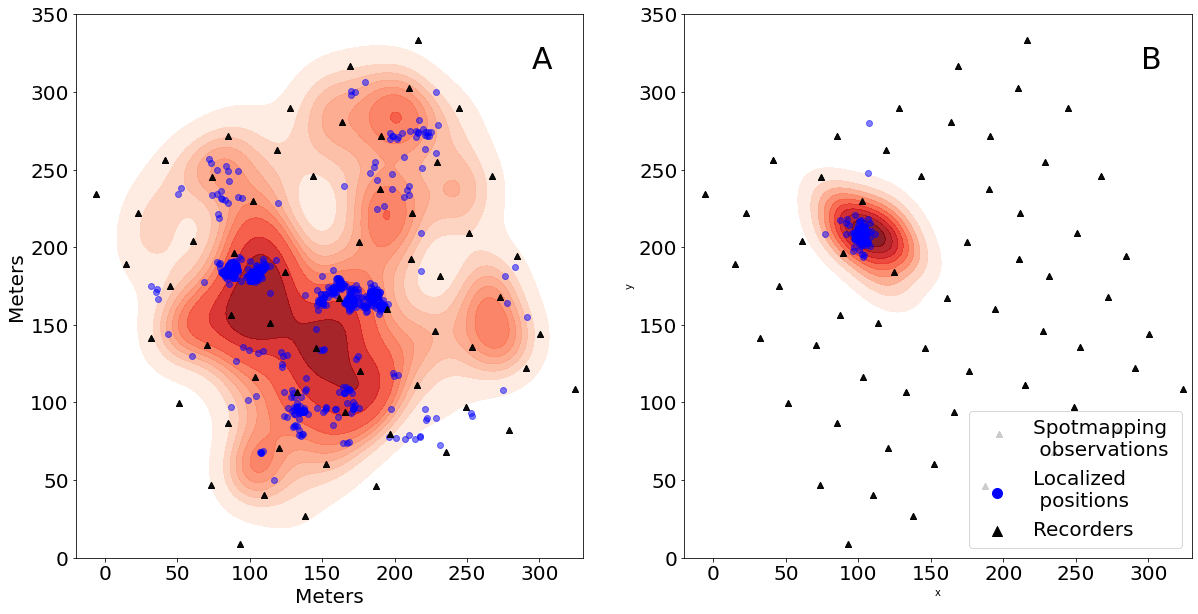

In [59]:
aru_coords = pd.read_csv("inputs/aru_coords.csv", index_col=0)
spotmap_obs = pd.read_csv("inputs/All_sp_spotmaps.csv")
pipeline_obs = pd.read_csv("./output_data/All_localizations.csv")
plt.rcParams["figure.figsize"] = (20, 10)

species = ["OVEN", "COYE"]

fig, ax = plt.subplots(1, len(species))

ax = ax.flatten()

ylims = [4461300, 4461650]
xlims = [664980, 665330]

for i, sp in enumerate(species):
    df = spotmap_obs[spotmap_obs["species"] == sp]
    df = remove_points_outside_convex_hull(df, aru_coords)

    # plot the heatmap of spotmap observations
    sns.kdeplot(df.x, df.y, ax = ax[i], cmap="Reds", shade=True, alpha = 0.9, bw_method = bw_dict[sp], label = "Spotmapping \n observations")

    # now add in the pipeline obs
    class_name = sp + "_song"
    pipeline_df = pipeline_obs[pipeline_obs["species"] == class_name]
    # drop the points outside the convex hull of the ARU locations
    pipeline_df = remove_points_outside_convex_hull(pipeline_df, aru_coords)
    ax[i].scatter(pipeline_df.x, pipeline_df.y, c="blue", label = "Localized \n positions", alpha=0.5)
    # add the recorders
    ax[i].scatter(aru_coords["x"], aru_coords["y"], c="black", marker="^", label="Recorders", alpha=0.5)

    # set lims 
    ax[i].set_ylim(ylims)
    ax[i].set_xlim(xlims)

    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)

    # the xtick values are too big, instead of showing 665050, show 50, (with +665000 in the label)
    xticks = ax[i].get_xticks()
    xticks = [str(int(x - 665000)) for x in xticks]
    ax[i].set_xticklabels(xticks)
    # do the same for yticks. But minus 4.461e6
    yticks = ax[i].get_yticks()
    yticks = [str(int(y - 4461300)) for y in yticks]
    ax[i].set_yticklabels(yticks)

# label x and y of only one sublpot
ax[0].set_xlabel('Meters', fontsize=20)
ax[0].set_ylabel('Meters', fontsize=20)

# hide unused axes
for j in range(i+1, len(ax)):
    ax[j].axis("off")

# add a single legend to the right
ax[1].legend(loc='lower right', fontsize=20)

ax[0].annotate("A", xy=(0.9, 0.9), xycoords="axes fraction", fontsize=30)
ax[1].annotate("B", xy=(0.9, 0.9), xycoords="axes fraction", fontsize=30)

# increase the size of the legend icons
leg = ax[1].get_legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([100])

plt.savefig("output_data/heatmap.png", bbox_inches = "tight")